In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
trend_train = np.arange(11,111, dtype='float64') + np.random.normal(scale=2, size=100)
trend_test_outofrange = np.arange(111,131, dtype='float64') + np.random.normal(scale=2, size=20)
trend_test_inrange = np.arange(31,51, dtype='float64') + np.random.normal(scale=2, size=20)

In [3]:
train = trend_train
test = trend_test_outofrange

In [4]:
lstm_num_predictions = 5

lstm_stateful = True
lstm_num_timesteps = 4 # for diffed series
effective_timesteps = lstm_num_timesteps+1
num_neurons = 4
batchsize = 1
num_epochs = 5

In [5]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return(diff)

def inverse_difference(history, yhat, interval=1):
    # history[-len(series)] is first item, history[-len(series) - 1] is second, etc. 
    return yhat + history[-interval]

In [6]:
train_diff = difference(train, 1)
test_diff = difference(test, 1)
test_diff

[4.5584643679563897,
 0.33804596082947569,
 -1.5201184069377689,
 1.7486714707211206,
 -0.18119266405436463,
 1.5720270612310827,
 1.4578341062771614,
 -2.2047558352407464,
 2.2039912665931922,
 1.9469257691628314,
 -0.88857117014900666,
 -1.4848153254617387,
 3.7188198600422311,
 0.88062480326006209,
 1.7982437534353721,
 1.5885222024935786,
 -0.1536246263263763,
 0.10948671764545281,
 4.0889710912433799]

In [8]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


values = [x for x in range(10)]
data = series_to_supervised(values,3,3)
print(data)

   var1(t-3)  var1(t-2)  var1(t-1)  var1(t)  var1(t+1)  var1(t+2)
3        0.0        1.0        2.0        3        4.0        5.0
4        1.0        2.0        3.0        4        5.0        6.0
5        2.0        3.0        4.0        5        6.0        7.0
6        3.0        4.0        5.0        6        7.0        8.0
7        4.0        5.0        6.0        7        8.0        9.0


In [9]:
train_diff_df = series_to_supervised(train_diff,lstm_num_timesteps, lstm_num_predictions)
test_diff_df = series_to_supervised(test_diff,lstm_num_timesteps, lstm_num_predictions)
test_diff_df

,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4)
4,4.558464,0.338046,-1.520118,1.748671,-0.181193,1.572027,1.457834,-2.204756,2.203991
5,0.338046,-1.520118,1.748671,-0.181193,1.572027,1.457834,-2.204756,2.203991,1.946926
6,-1.520118,1.748671,-0.181193,1.572027,1.457834,-2.204756,2.203991,1.946926,-0.888571
7,1.748671,-0.181193,1.572027,1.457834,-2.204756,2.203991,1.946926,-0.888571,-1.484815
8,-0.181193,1.572027,1.457834,-2.204756,2.203991,1.946926,-0.888571,-1.484815,3.718820
9,1.572027,1.457834,-2.204756,2.203991,1.946926,-0.888571,-1.484815,3.718820,0.880625
10,1.457834,-2.204756,2.203991,1.946926,-0.888571,-1.484815,3.718820,0.880625,1.798244
11,-2.204756,2.203991,1.946926,-0.888571,-1.484815,3.718820,0.880625,1.798244,1.588522
12,2.203991,1.946926,-0.888571,-1.484815,3.718820,0.880625,1.798244,1.588522,-0.153625
13,1.946926,-0.888571,-1.484815,3.718820,0.880625,1.798244,1.588522,-0.153625,0.109487


In [10]:
train_diff_matrix = train_diff_df.values
test_diff_matrix = test_diff_df.values

In [11]:
train_diff_matrix[:5,:]

array([[ 0.76773845,  6.46948997, -2.65785188, -2.68560912,  1.58375225,
         1.87621952,  1.99784435, -0.40096689,  4.35622193],
       [ 6.46948997, -2.65785188, -2.68560912,  1.58375225,  1.87621952,
         1.99784435, -0.40096689,  4.35622193, -0.69211545],
       [-2.65785188, -2.68560912,  1.58375225,  1.87621952,  1.99784435,
        -0.40096689,  4.35622193, -0.69211545,  1.27601494],
       [-2.68560912,  1.58375225,  1.87621952,  1.99784435, -0.40096689,
         4.35622193, -0.69211545,  1.27601494, -0.35614738],
       [ 1.58375225,  1.87621952,  1.99784435, -0.40096689,  4.35622193,
        -0.69211545,  1.27601494, -0.35614738,  3.13249379]])

In [12]:
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]


In [13]:
scaler, train_scaled, test_scaled = scale(train_diff_matrix, test_diff_matrix)
test_scaled

array([[ 0.52306408,  0.09245201, -0.09713772,  0.23637906,  0.03947376,
         0.21835592,  0.20670474, -0.16699172,  0.28283564],
       [ 0.09245201, -0.09713772,  0.23637906,  0.03947376,  0.21835592,
         0.20670474, -0.16699172,  0.28283564,  0.25660708],
       [-0.09713772,  0.23637906,  0.03947376,  0.21835592,  0.20670474,
        -0.16699172,  0.28283564,  0.25660708, -0.03270054],
       [ 0.23637906,  0.03947376,  0.21835592,  0.20670474, -0.16699172,
         0.28283564,  0.25660708, -0.03270054, -0.09353572],
       [ 0.03947376,  0.21835592,  0.20670474, -0.16699172,  0.28283564,
         0.25660708, -0.03270054, -0.09353572,  0.4373946 ],
       [ 0.21835592,  0.20670474, -0.16699172,  0.28283564,  0.25660708,
        -0.03270054, -0.09353572,  0.4373946 ,  0.14781169],
       [ 0.20670474, -0.16699172,  0.28283564,  0.25660708, -0.03270054,
        -0.09353572,  0.4373946 ,  0.14781169,  0.24143696],
       [-0.16699172,  0.28283564,  0.25660708, -0.03270054, -0

In [13]:
def fit_lstm_stateful(train, batchsize, num_epochs, num_neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(num_neurons, batch_input_shape=(batchsize, X.shape[1], X.shape[2]),
                   stateful=True, return_sequences = True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Activation("linear"))  
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    for i in range(num_epochs):
        model.fit(X, y, epochs=1, batch_size=batchsize, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [14]:
def fit_lstm_stateless(train, batchsize, num_epochs, num_neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(num_neurons, batch_input_shape=(batchsize, X.shape[1], X.shape[2]), return_sequences = True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Activation("linear"))  
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    model.fit(X, y, epochs=num_epochs, batch_size=batchsize, verbose=1, shuffle=True)
    return model

In [15]:
def forecast_lstm(model, batch_size, X):
    if lstm_stateful:
         model.reset_states()
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [16]:
train_diff = difference(train, 1)
test_diff = difference(test, 1)
train_matrix = series_to_supervised(train_diff, lstm_num_timesteps).values
test_matrix = series_to_supervised(test_diff, lstm_num_timesteps).values
scaler, train_scaled, test_scaled = scale(train_matrix, test_matrix)

if lstm_stateful:
    lstm_model = fit_lstm_stateful(train_scaled, batchsize, num_epochs, num_neurons)
else:
    lstm_model = fit_lstm_stateless(train_scaled, batchsize, num_epochs, num_neurons)
        
train_predictions = list()
for i in range(len(train_scaled)):
    X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_difference(train, yhat, len(train_scaled)+1-i)
    train_predictions.append(yhat)
            
test_predictions = list()
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_difference(test, yhat, len(test_scaled)+1-i)
    test_predictions.append(yhat)
         
rmse = sqrt(mean_squared_error(test[effective_timesteps:], test_predictions))
print('Test RMSE: %.3f' % rmse)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4)                    144       
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.1866     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.1708     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.1621     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.1547     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.1477     
Test RMSE: 1.466


In [17]:
test_predictions[:10]

[115.83511658847435,
 115.89536638671774,
 117.55017190390456,
 117.91801063016634,
 118.05468461586976,
 120.71599495183632,
 122.1552885182834,
 124.04603650827961,
 123.16526810145027,
 124.86573475478588]

In [18]:
train_predictions[:10]

[13.524759336738766,
 16.902363321082717,
 17.920034731062021,
 18.196734300324277,
 21.773546757280482,
 21.189044437788453,
 25.789043281528116,
 24.614957906216549,
 22.981490711730327,
 24.292919435539218]

In [19]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    padding = [np.nan for i in range(effective_timesteps)]
    plt.plot(padding + predicted_data, label='Prediction')
    plt.legend()
    plt.show()

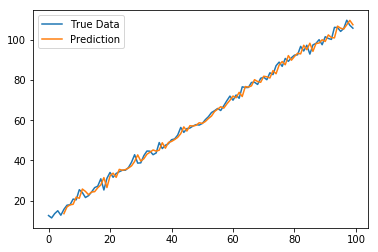

In [20]:
plot_results(train_predictions, train)

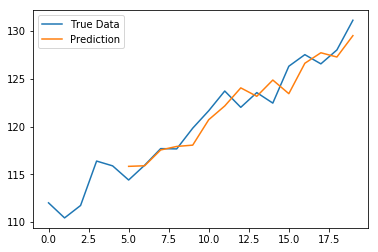

In [21]:
plot_results(test_predictions, test)